# Pre-lab setup

In [3]:
import pandas as pd
import numpy as np

import re

from sklearn import decomposition
# from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 4.7 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]


In [5]:
! pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pyLDAvis]2/3 [pyLDAvis]


In [ ]:
# gensim for LDA
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
## set read/write paths for easy access
file_path = '/content/drive/MyDrive/Year One/Fall/NLP/Lab5'

## LSA Helpers

In [8]:
def batch_lsa(id2word, corpus, texts, stop, start, step, coherence_measure='c_v'):
  # initialize lists
  coherence_scores = []
  model_list = []

  for n_topics in range(start, stop+1, step):
    # train model
    lsa_model = LsiModel(
        corpus,
        id2word=id2word,
        num_topics=n_topics
    )

    # Store model
    model_list.append(lsa_model)

    # calculate coherence
    coherence_model_lsa = CoherenceModel(
        model=lsa_model,
        texts=texts,
        dictionary=id2word,
        coherence=coherence_measure
    )
    # store coherence
    coherence_scores.append(coherence_model_lsa.get_coherence())

  return model_list, coherence_scores


In [25]:
def vis_lsa(lsa_model, n_words=15):
  topic_words = pd.DataFrame({})

  for i, topic in enumerate(lsa_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value' : feature_values, 'word' : words, 'topic' : i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

  g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
  g.map(plt.barh, "word", "value")

## LDA Helpers

In [9]:
## creates a set of LDA models and also returns coherence metric
def batch_lda(corpus, id2word, start, stop, step, chunksize=1500, passes=20, iterations=400, eval_every=None, gamma_threshold=0.001, alpha='auto', eta='auto', coherence_measure='c_v'):

  # initialize lists
  coherence_scores = []
  model_list = []

  for n_topics in range(start, stop, step):

    # train LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                chunksize=chunksize,
                                                passes = passes,
                                                alpha=alpha,
                                                eta=eta,
                                                iterations=iterations,
                                                num_topics=n_topics,
                                                per_word_topics=True,
                                                eval_every=eval_every,
                                                gamma_threshold=gamma_threshold)

    model_list.append(lda_model)

    ## calculate coherence
    coherence_model_lda = CoherenceModel(model=lda_model,
                                      texts=texts,
                                      dictionary=id2word,
                                      coherence=coherence_measure)

    coherence_scores.append(coherence_model_lda.get_coherence())

  return model_list, coherence_scores

# Part 1: Prep the Data

In [12]:
review_df = pd.read_csv(f"data/review_tokenized.csv", header=0, index_col=0)
print(review_df.head())

                      Appname  \
recommendationid                
212664845         ARC Raiders   
212664705         ARC Raiders   
212664692         ARC Raiders   
212664560         ARC Raiders   
212664471         ARC Raiders   

                                                     review_cleaned  
recommendationid                                                     
212664845                           addictive stressful time waster  
212664705         steam comment section like every comment secti...  
212664692         like gathering sneak around arc pvp part peopl...  
212664560         well make game every time hop experience somet...  
212664471         think would sweaty honestly somehow stop playi...  


In [ ]:
review_df.shape

(63208, 9)

## Check for Digits or Punctuation

In [14]:
## use regex to check for special characters
review_df['contains_special_characters'] = review_df['review_cleaned'].apply(lambda x:re.search(r"[^\w\s]+", x))
review_df['contains_special_characters'].head()

recommendationid
212664845    None
212664705    None
212664692    None
212664560    None
212664471    None
Name: contains_special_characters, dtype: object

In [15]:
## will return true if any of these cleaned reviews contain non-word, non-space characters
review_df['contains_special_characters'].any()

np.True_

# Part 2: Create the Dictionary

In [16]:
from gensim.models.phrases import Phrases, Phraser

In [18]:
# create a stream of sequence
sent = [text.split() for text in review_df['review_cleaned']]
bigram = Phrases(sent, min_count=40)

bigram_phraser = Phraser(bigram)

In [19]:
# apply the exported model to each review of the corpus
texts = bigram_phraser[sent]

In [20]:
# build the id2word dictionary
id2word = Dictionary(texts)

# filter very frequently and rare tokens
id2word.filter_extremes(no_below=60, no_above=0.50)


In [21]:
print("Size of dictionary: ", len(id2word))

Size of dictionary:  2422


# Part 3: LSA using BOW

In [22]:
## create corpus
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
## run the bag of words model
bow_models, bow_coherence = batch_lsa(id2word, bow_corpus, texts, 10, 2, 2, coherence_measure='c_v')

bow_coherence

[np.float64(0.475434657522862),
 np.float64(0.4456231265860843),
 np.float64(0.457514775272376),
 np.float64(0.4332384333951945),
 np.float64(0.4387195050846323)]

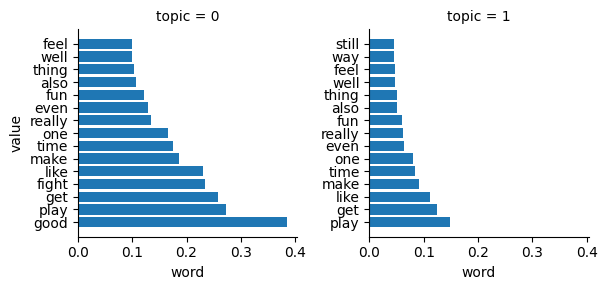

In [45]:
vis_lsa(bow_models[0])

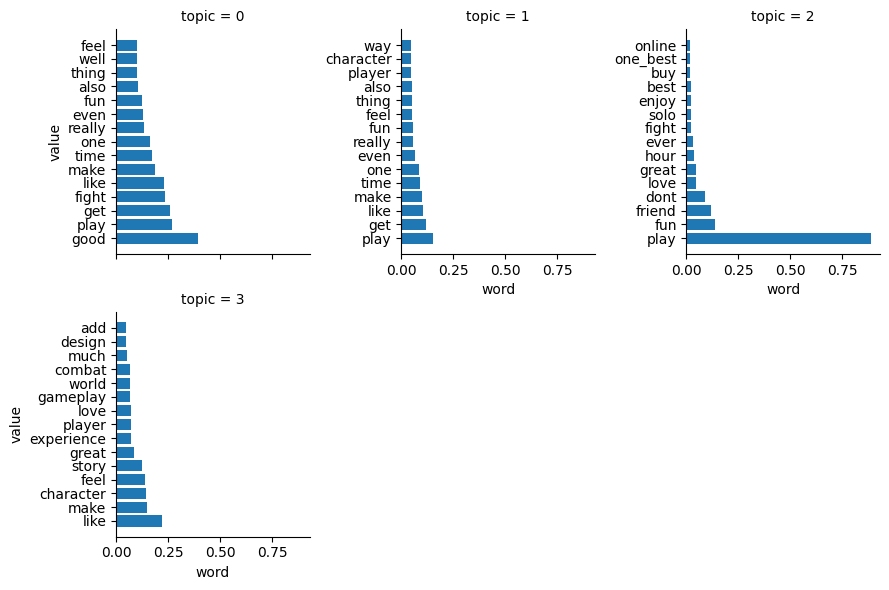

In [46]:
vis_lsa(bow_models[1])

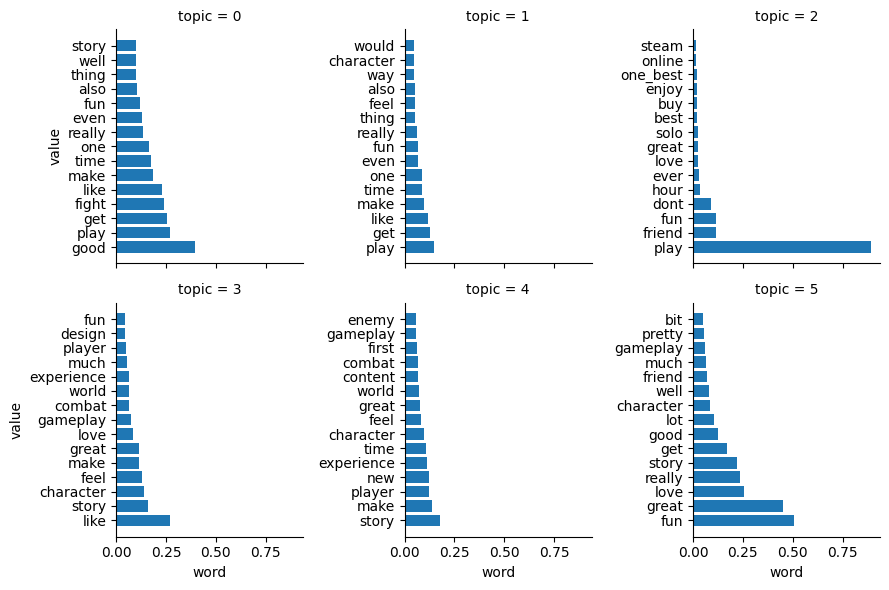

In [47]:
vis_lsa(bow_models[2])

# Part 4: LSA using TFIDF

In [29]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]

In [30]:
## run the tfidf LSA models
tfidf_models, tfidf_coherence = batch_lsa(id2word, tfidf_corpus, texts, 10, 2, 2, coherence_measure='c_v')

tfidf_coherence

[np.float64(0.39116668832611917),
 np.float64(0.4059364367676344),
 np.float64(0.41704940662584894),
 np.float64(0.4077561451962393),
 np.float64(0.4129771049560282)]

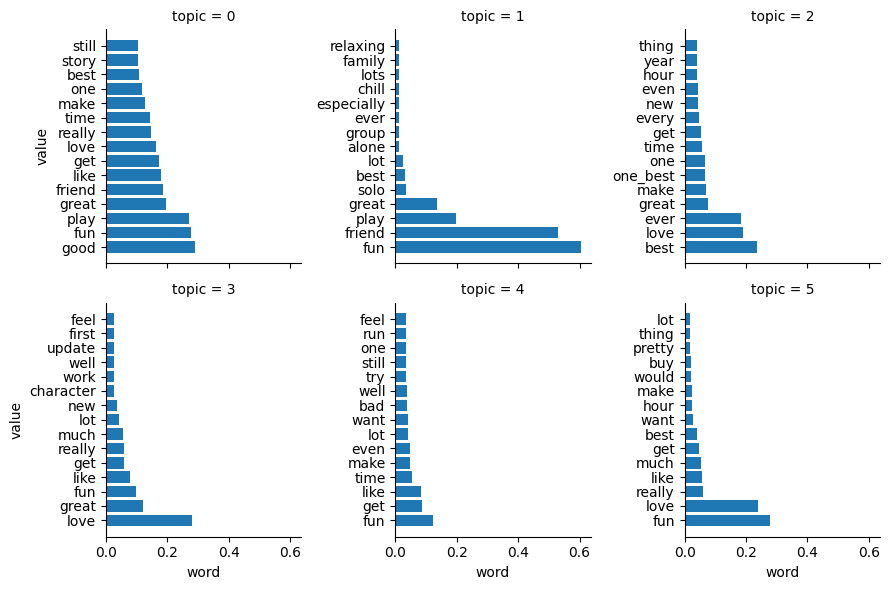

In [44]:
vis_lsa(tfidf_models[2])

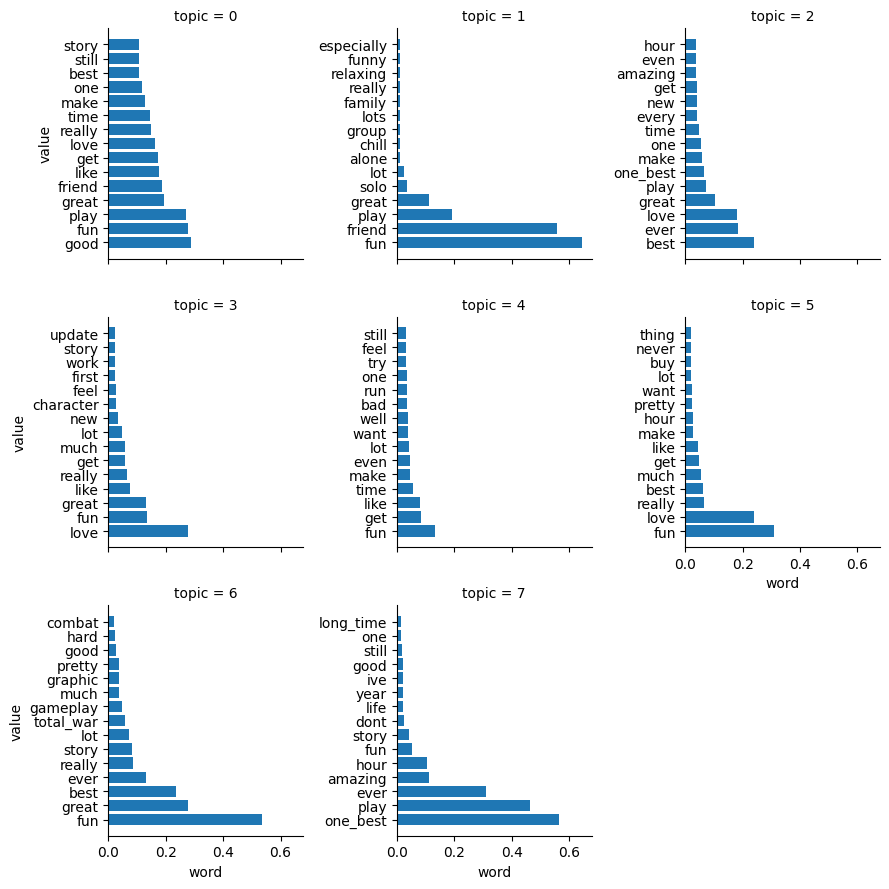

In [43]:
vis_lsa(tfidf_models[3])

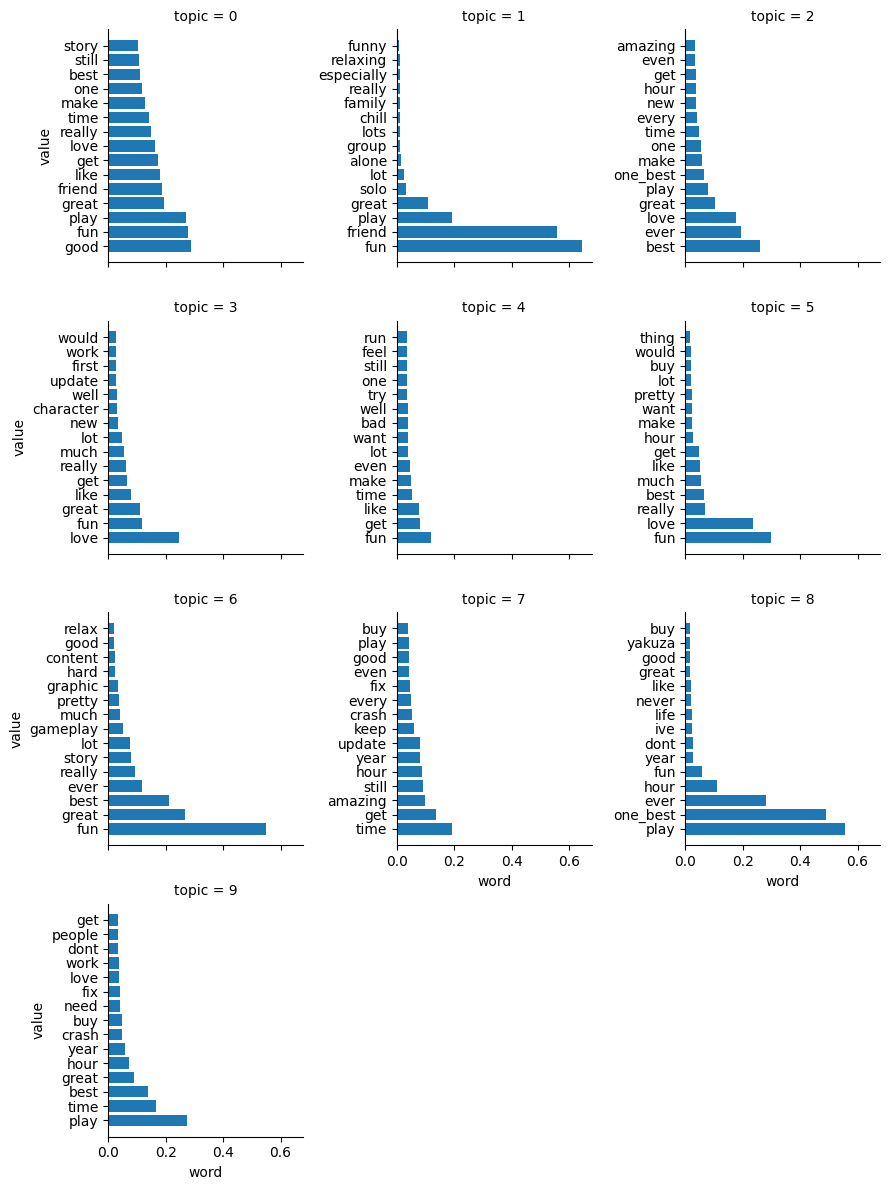

In [42]:
vis_lsa(tfidf_models[4])

# Part 5: LDA

In [34]:
## run the lda models
lda_models, lda_coherence = batch_lda(bow_corpus, id2word, 4, 18, 2, coherence_measure='c_v')

lda_coherence

[np.float64(0.4542991804681784),
 np.float64(0.46770627189702135),
 np.float64(0.41630772731417204),
 np.float64(0.39567631899808414),
 np.float64(0.4370763065183823),
 np.float64(0.4248814621491969),
 np.float64(0.4016378475770974)]

## Coherence Plot

range(4, 18, 2)
[np.float64(0.4542991804681784), np.float64(0.46770627189702135), np.float64(0.41630772731417204), np.float64(0.39567631899808414), np.float64(0.4370763065183823), np.float64(0.4248814621491969), np.float64(0.4016378475770974)]


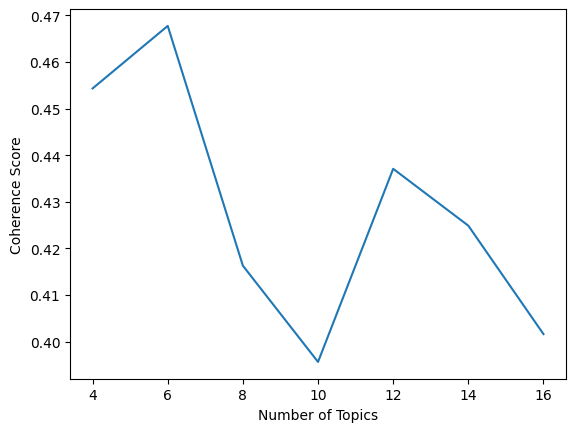

In [35]:
## visualize coherence scores together
x = range(4, 18, 2)
y = lda_coherence

print(x)
print(y)

plt.plot(x, y)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

## 4 topics

In [48]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[0], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.137714  0.067649       1        1  55.595668
0     -0.174578  0.246824       2        1  21.466501
2     -0.088636 -0.364584       3        1  12.477144
3      0.400927  0.050112       4        1  10.460686, topic_info=       Term          Freq         Total Category  logprob  loglift
82     play  19691.000000  19691.000000  Default  30.0000  30.0000
137    good  13246.000000  13246.000000  Default  29.0000  29.0000
36      fun  11969.000000  11969.000000  Default  28.0000  28.0000
56     like  13373.000000  13373.000000  Default  27.0000  27.0000
178   great   9249.000000   9249.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
112    well   2108.836636   5442.099234   Topic4  -3.9143   1.3095
304   fight    966.835215   1639.282865   Topic4  -4.6942   1.7296
82     play   1331.829639  19691.728468   Topic4  -4.3739  -0.4361
413  boring    584.615817    729.472911   Topic4  -5.1973   2.0362
39      get    662.128375  13461.238014   Topic4  -5.0727  -0.7546

[239 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
464       1  0.999391      able
945       1  0.002135  absolute
945       3  0.997194  absolute
845       2  0.998815    action
4         1  0.999757  actually
...     ...       ...       ...
159       1  0.150759      year
159       3  0.848799      year
358       1  0.208017       yes
358       4  0.791845       yes
1502      3  0.999161    zombie

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

## 6 topics

In [49]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[1], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.068276 -0.021284       1        1  29.830787
4     -0.038395  0.040841       2        1  20.818027
0      0.161624  0.199328       3        1  16.615554
5      0.229594  0.033314       4        1  15.359897
1     -0.036343 -0.384253       5        1  11.340688
2     -0.384757  0.132054       6        1   6.035047, topic_info=        Term          Freq         Total Category  logprob  loglift
137     good  13801.000000  13801.000000  Default  30.0000  30.0000
56      like  13694.000000  13694.000000  Default  29.0000  29.0000
82      play  17863.000000  17863.000000  Default  28.0000  28.0000
39       get  13336.000000  13336.000000  Default  27.0000  27.0000
36       fun  11163.000000  11163.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
181    break    873.102263   1010.348538   Topic6  -4.2461   2.6616
93       run   1252.002759   3705.690142   Topic6  -3.8857   1.7225
159     year    861.051172   1803.633742   Topic6  -4.2600   2.0682
441  problem    669.252545   1136.555179   Topic6  -4.5120   2.2780
23      even    979.945938   6294.457258   Topic6  -4.1307   0.9477

[349 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
900       1  0.034218     ability
900       5  0.965827     ability
532       2  0.999264  absolutely
240       1  0.953748         add
240       3  0.032105         add
...     ...       ...         ...
915       3  0.996972        yeah
159       2  0.522279        year
159       6  0.477370        year
358       3  0.998608         yes
1502      2  0.998608      zombie

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 6, 2, 3])

## 12 topics

In [38]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[4], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.213539 -0.069106       1        1  19.479067
1      0.199769  0.011230       2        1  15.906684
0      0.216654 -0.121846       3        1  14.623844
5      0.198674 -0.085854       4        1  14.058507
11     0.049870  0.258518       5        1  12.278245
2     -0.002632  0.302443       6        1   5.437941
10    -0.126511  0.032479       7        1   4.041573
4     -0.156579  0.111864       8        1   3.629010
3     -0.143326 -0.153187       9        1   3.171926
9     -0.126378 -0.085382      10        1   2.890408
8     -0.146043 -0.092326      11        1   2.629713
6     -0.177035 -0.108834      12        1   1.853083, topic_info=           Term          Freq         Total Category  logprob  loglift
82         play  18798.000000  18798.000000  Default  30.0000  30.0000
137        good  13360.000000  13360.000000  Default  29.0000  29.0000
56         like  12985.000000  12985.000000  Default  28.0000  28.0000
36          fun  12072.000000  12072.000000  Default  27.0000  27.0000
178       great   8791.000000   8791.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2279    kingdom    173.687279    174.599982  Topic12  -4.6802   3.9831
1079       buck    171.908993    172.821661  Topic12  -4.6905   3.9830
1923       flow    164.575110    165.487795  Topic12  -4.7341   3.9828
2066       rule    159.326646    160.239325  Topic12  -4.7665   3.9826
1958  variation    152.662859    153.575562  Topic12  -4.8092   3.9824

[527 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
900       6  0.999089      ability
464       2  0.998784         able
1596      6  0.997404  achievement
477      12  0.998237          act
845       5  0.997835       action
...     ...       ...          ...
358       2  0.003454          yes
358       3  0.995772          yes
1981     11  0.997318         zero
1502     11  0.999068       zombie
1473     10  0.995880         zone

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 6, 12, 3, 11, 5, 4, 10, 9, 7])